RANDOM FOREST
Nel file preprocessing_for_adult.py sono contenute le funzioni per il preprocessing da applicare ad adult.data: la prima (preprocessing_funct_not_enc) discretizza, normalizza ecc mentre la seconda (encoding_funct) esegue l'encoding.

In [85]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare, encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch


from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
from divexplorer.outcomes import get_false_positive_rate_outcome

In [86]:
torch.manual_seed(42)
pd.options.display.float_format = '{:.3f}'.format

In [87]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)

In [88]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [89]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


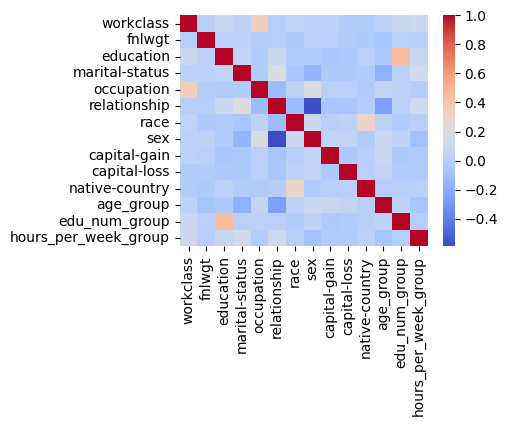

In [90]:
df_train_no_income = df_train_enc.drop(columns = 'income')
plt.figure(figsize=(4, 3))
g = sns.heatmap(df_train_no_income.corr(),
                annot = False,
                cmap = "coolwarm")


In [91]:
#RANDOM FOREST CLASSIFIER
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = RandomForestClassifier(random_state=42)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()


In [92]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [93]:
#predizioni per il validation set
y_pred_val = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [94]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fp' a df_val non encoded
df_val['fp'] = df_val_class['fp']

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,fp,y_pred,accuracy
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,0.000,0,1
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,NaN,0,0
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,0.000,0,1
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,NaN,1,1
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,0.000,0,1


ANALISI CONDOTTA CON LA FEATURE FP (PASSATA A BOOLEAN OUTCOME)


In [95]:
fp_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.2, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.239,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.349,0.258,15.675,8,1554.000
1,0.239,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.349,0.258,15.675,6,1554.000
2,0.239,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.349,0.258,15.675,7,1554.000
3,0.239,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.349,0.258,15.675,7,1554.000
4,0.243,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, native-country=United-States, capital-loss=0.0)",0.341,0.251,15.456,7,1578.000


In [96]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
df_pruned_fp.head()

,support,itemset,length,support_count,fp,fp_div,fp_t
7,0.259,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States)",5,1686.000,0.340,0.250,15.545
19,0.284,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, native-country=United-States)",5,1848.000,0.326,0.236,15.526
25,0.297,"(race= White, native-country=United-States, hours_per_week_group=Overtime, relationship= Husband)",4,1931.000,0.323,0.233,15.141
30,0.279,"(race= White, hours_per_week_group=Overtime, capital-gain=0.0, relationship= Husband)",4,1817.000,0.322,0.232,15.281
35,0.280,"(native-country=United-States, hours_per_week_group=Overtime, capital-gain=0.0, relationship= Husband)",4,1820.000,0.318,0.228,15.022


ANALISI SU SHAPLEY VALUES

In [97]:
'''#LOCAL
fp_details = DivergencePatternProcessor(FP_fm, 'fp')
pattern = fp_details.patterns['itemset'].iloc[0]
print(pattern)
sv = fp_details.shapley_value(pattern)
sv
(relationship= Husband, hours_per_week_group=Overtime, capital-gain=0.0, native-country=United-States)'''

"#LOCAL\nfp_details = DivergencePatternProcessor(FP_fm, 'fp')\npattern = fp_details.patterns['itemset'].iloc[0]\nprint(pattern)\nsv = fp_details.shapley_value(pattern)\nsv\n(relationship= Husband, hours_per_week_group=Overtime, capital-gain=0.0, native-country=United-States)"

In [98]:
'''#GLOBAL
gsv = fp_details.global_shapley_value()
gsv
#order gsv desc
sorted_gsv = sorted(gsv.items(), key=lambda x: x[1], reverse=True)

# extract itemset and Shapley values
itemsets = [' '.join(item) for item, value in sorted_gsv]
shapley_values = [value for item, value in sorted_gsv]

# Colours
colors = ['#FFC0CB', '#FF69B4', '#FF1493', '#FF7F50', '#FFA07A', '#FF6347', '#FF4500', '#FA8072', '#FFD700', '#FFA500', '#FF8C00', '#FFDAB9', '#FFE4B5', '#F08080']

# Graph of Shapley values
plt.figure(figsize=(8, 6))
bars = plt.barh(itemsets, shapley_values, color=colors[:len(itemsets)])
plt.xlabel('Shapley Value')
plt.title('Global Shapley Values')

# Add numbers
#for i, value in enumerate(shapley_values):
#    plt.text(value + 0.0005, i, format(value, '.4f'), va='center', ha='left', color='black')

plt.gca().invert_yaxis() 
plt.xlim(-0.020, 0.015)
plt.tight_layout()
plt.show()'''

"#GLOBAL\ngsv = fp_details.global_shapley_value()\ngsv\n#order gsv desc\nsorted_gsv = sorted(gsv.items(), key=lambda x: x[1], reverse=True)\n\n# extract itemset and Shapley values\nitemsets = [' '.join(item) for item, value in sorted_gsv]\nshapley_values = [value for item, value in sorted_gsv]\n\n# Colours\ncolors = ['#FFC0CB', '#FF69B4', '#FF1493', '#FF7F50', '#FFA07A', '#FF6347', '#FF4500', '#FA8072', '#FFD700', '#FFA500', '#FF8C00', '#FFDAB9', '#FFE4B5', '#F08080']\n\n# Graph of Shapley values\nplt.figure(figsize=(8, 6))\nbars = plt.barh(itemsets, shapley_values, color=colors[:len(itemsets)])\nplt.xlabel('Shapley Value')\nplt.title('Global Shapley Values')\n\n# Add numbers\n#for i, value in enumerate(shapley_values):\n#    plt.text(value + 0.0005, i, format(value, '.4f'), va='center', ha='left', color='black')\n\nplt.gca().invert_yaxis() \nplt.xlim(-0.020, 0.015)\nplt.tight_layout()\nplt.show()"

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Random forest nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [99]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, 5) #da aggiungere a train set e ripetere train e test

df_combinated = pd.concat([df_holdout_filtered, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=42).reset_index(drop=True)

In [100]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  15416
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  2402
TEST SET FILTERED ROWS:  6507


In [101]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = RandomForestClassifier(random_state=42)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [102]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
"After Mitigation(K=5, fp)",0.843,0.659,0.090,0.370,444,580,15416,6508


Performance su sottogruppi 

In [103]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_fp, df_test, 5)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Random Forest performance when boolean outcomes = fp")
metrics_after_fp_sottogruppi

Subgroups Random Forest performance when boolean outcomes = fp


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.701,0.678,0.259,0.343,329,400,13014,2435
"After Mitigation(K=5, on subgroups, fp)",0.700,0.682,0.272,0.330,345,385,15416,2435


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE
SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

In [104]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, 5)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) 
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)

Righe del dataset filtrato qunado K = 5 2356
numero di dati simulati con smotenc 2516
income
0    1258
1    1258
Name: count, dtype: int64


In [105]:
sampling_strategy = {0: 2500, 1: 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print(len(y_resampled))

class_counts = y_resampled.value_counts()
print(class_counts)

3700
income
0    2500
1    1200
Name: count, dtype: int64


In [106]:
X_train_mitigated_SMOTE = pd.concat([X_train, X_resampled], ignore_index=True)
y_train_mitigated_SMOTE = pd.concat([y_train, y_resampled], ignore_index=True)
print(len(X_train_mitigated_SMOTE))

classifier_train_mitigated_SMOTE = RandomForestClassifier(random_state=42)
classifier_train_mitigated_SMOTE.fit(X_train_mitigated_SMOTE, y_train_mitigated_SMOTE)
y_mitigated_SMOTE_pred = classifier_train_mitigated_SMOTE.predict(X_test)

16714


In [107]:
accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred )

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE, f1_score_fp_after_SMOTE, fpr_fp_after_SMOTE, fnr_fp_after_SMOTE, fp_fp_after_SMOTE, fn_fp_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_mitigated_SMOTE_pred)]
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)
    
metrics_after_fp_SMOTE

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
After SMOTE fp mitigation,0.837,0.637,0.086,0.407,424,638,16714,6508


A QUESTO PUNTO POSSIAMO VEDERE LE PERFORMANCE SUI SOTTOGRUPPI PRIMA E DOPO 

In [108]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_fp_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_fp)

#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE )

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_fp_sottogruppi_after_SMOTE, f1_score_fp_sottogruppi_after_SMOTE, fpr_fp_sottogruppi_after_SMOTE, fnr_fp_sottogruppi_after_SMOTE, fp_fp_sottogruppi_after_SMOTE, fn_fp_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_fp_after_SMOTE)],
})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE

print("Subgroups Random forest when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Random forest when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.701,0.678,0.259,0.343,329,400,13014,2435
"After Mitigation(K=5, on subgroups, fp and SMOTE)",0.688,0.658,0.254,0.375,322,437,16714,2435


ANALISI CONDOTTA CON LA FEATURE ACCURACY (PASSATA A BOOLEAN OUTCOME)

In [109]:
accuracy_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
ACCURACY_fm = accuracy_diver.get_pattern_divergence(min_support=0.2, attributes=attributes, boolean_outcomes=['accuracy'])
ACCURACY_fm = ACCURACY_fm.sort_values(by="accuracy_div", ascending=True, ignore_index=True)
pd.set_option('display.max_colwidth', None)
ACCURACY_fm.head()

,support,itemset,accuracy,accuracy_div,accuracy_t,length,support_count
0,0.239,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.607,-0.235,17.841,8,1554.000
1,0.239,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.607,-0.235,17.841,6,1554.000
2,0.239,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.607,-0.235,17.841,7,1554.000
3,0.239,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",0.607,-0.235,17.841,7,1554.000
4,0.243,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, sex= Male, native-country=United-States, capital-loss=0.0)",0.610,-0.232,17.768,7,1578.000


In [110]:
#pruning 
accuracy_details = DivergencePatternProcessor(ACCURACY_fm, 'accuracy')
df_pruned_acc = accuracy_details.redundancy_pruning(th_redundancy=0.01)
df_pruned_acc = df_pruned_acc.sort_values("accuracy_div", ascending=True)
df_pruned_acc.head()

,support,itemset,length,support_count,accuracy,accuracy_div,accuracy_t
1,0.239,"(race= White, capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",6,1554.000,0.607,-0.235,17.841
5,0.262,"(race= White, marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, native-country=United-States, capital-loss=0.0)",6,1707.000,0.614,-0.229,18.125
7,0.258,"(capital-gain=0.0, hours_per_week_group=Overtime, relationship= Husband, native-country=United-States, capital-loss=0.0)",5,1679.000,0.619,-0.223,17.606
15,0.272,"(race= White, capital-gain=0.0, relationship= Husband, native-country=United-States, capital-loss=0.0)",5,1769.000,0.626,-0.217,17.547
19,0.286,"(marital-status=Married, capital-gain=0.0, hours_per_week_group=Overtime, native-country=United-States, capital-loss=0.0)",5,1859.000,0.628,-0.215,17.778


In [111]:
prun_size = df_pruned_acc.shape
original_size = ACCURACY_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (893, 7)
Dim pruned th_redundancy  (140, 7)


BIAS MITIGATION

In [112]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned = df_pruned_acc, df_holdout=df_holdout, K = 5)
df_combinated = pd.concat([df_holdout_filtered, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=42).reset_index(drop=True) 

In [113]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_accuracy = df_train_enc_mit
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit_accuracy.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  15098
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  2084
TEST SET FILTERED ROWS:  6507


In [114]:
X_train_mitigated = df_train_enc_mit_accuracy.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit_accuracy['income']

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [115]:
accuracy_acc_after, f1_score_acc_after, fpr_acc_after, fnr_acc_after, fp_acc_after, fn_acc_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
metrics_after_accuracy = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
    'After Mitigation(K=5, all matching data, accuracy)': [accuracy_acc_after, f1_score_acc_after, fpr_acc_after, fnr_acc_after, fp_acc_after, fn_acc_after, len(y_test)],
})
metrics_after_accuracy = metrics_after_accuracy.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives',  'Test Size']

for metric in metrics_to_cast:
    metrics_after_accuracy[metric] = metrics_after_accuracy[metric].astype(int)

metrics_after_accuracy
print("Overall Random Forest performance when boolean outcomes = accuracy")
metrics_after_accuracy

Overall Random Forest performance when boolean outcomes = accuracy


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,6508
"After Mitigation(K=5, all matching data, accuracy)",0.843,0.658,0.089,0.371,442,582,6508


Performance su sottogruppi

In [116]:
df_test_filtered_acc = K_subgroups_dataset_and_or(df_pruned_acc, df_test, 5)
inutile, df_test_filtered_enc_acc, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_acc, df_holdout, df_val)

X_test_filtered_acc = df_test_filtered_enc_acc.drop(columns='income', axis = 1)
y_true_test_filtered_acc = df_test_filtered_enc_acc['income']

y_pred_test_filtered_acc_before = classifier_train.predict(X_test_filtered_acc)
y_pred_test_filtered_acc_after = classifier_train_mitigated.predict(X_test_filtered_acc)

accuracy_acc_sottogruppi_before, f1_score_acc_sottogruppi_before, fpr_acc_sottogruppi_before, fnr_acc_sottogruppi_before, fp_acc_sottogruppi_before, fn_acc_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_acc, y_pred = y_pred_test_filtered_acc_before )
accuracy_acc_sottogruppi_after, f1_score_acc_sottogruppi_after, fpr_acc_sottogruppi_after, fnr_acc_sottogruppi_after, fp_acc_sottogruppi_after, fn_acc_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_acc, y_pred = y_pred_test_filtered_acc_after )


metrics_after_acc_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_acc_sottogruppi_before, f1_score_acc_sottogruppi_before, fpr_acc_sottogruppi_before, fnr_acc_sottogruppi_before, fp_acc_sottogruppi_before, fn_acc_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, accuracy)': [accuracy_acc_sottogruppi_after, f1_score_acc_sottogruppi_after, fpr_acc_sottogruppi_after, fnr_acc_sottogruppi_after, fp_acc_sottogruppi_after, fn_acc_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
})
metrics_after_acc_sottogruppi = metrics_after_acc_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_acc_sottogruppi[metric] = metrics_after_acc_sottogruppi[metric].astype(int)


print("Subgroups Random Forest performance when boolean outcomes = accuracy")
metrics_after_acc_sottogruppi

Subgroups Random Forest performance when boolean outcomes = accuracy


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.661,0.547,0.254,0.474,331,394,13014,2435
"After Mitigation(K=5, on subgroups, accuracy)",0.661,0.555,0.264,0.457,344,380,15098,2435


Conclusione su questa parte, vediamo:

- Analisi OVERALL: confronto tra metriche before mit, metriche con fp, metriche con accuracy
- Analisi su sottogruppi: 
                        before mit quindi quando train set è quello iniziale e y_test ha i sottogruppi di fp e accuracy (separatamente)
                        after mit quindi quando train set è quello mitigato e y_test ha i sottogruppi di fp e accuracy (separatamente)

ANALISI OVERALL: la mitigation fatta usando i sottogruppi generati dall'analisi condotta con i falsi positivi sembra migliorare le performance anche con meno dati di training.

Anche usando il parametro "accuracy" migliora le perfomance, ma meno significativamente

In [117]:
#dataframe che contine metriche 
comparison_df_overall = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size', 'Train Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test), len(y_train)],
    'After Mitigation(K=5, all matching data, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_test), len(df_train_enc_mit_fp)],
    'After Mitigation(K=5, all matching data, accuracy)' : [accuracy_acc_after, f1_score_acc_after, fpr_acc_after, fnr_acc_after, fp_acc_after, fn_acc_after, len(y_test), len(df_train_enc_mit_accuracy)  ]
})
comparison_df_overall = comparison_df_overall.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    comparison_df_overall[metric] = comparison_df_overall[metric].astype(int)


print("Overall Random Forest performance")
comparison_df_overall

Overall Random Forest performance


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size,Train Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,6508,13014
"After Mitigation(K=5, all matching data, fp)",0.843,0.659,0.090,0.370,444,580,6508,15416
"After Mitigation(K=5, all matching data, accuracy)",0.843,0.658,0.089,0.371,442,582,6508,15098


mentre le performaance sui sottogruppi prima e dopo la mitigation sono: 

In [118]:
comparison_df_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size', 'Train Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test), len(y_train)],
    'After Mitigation(K=5, sottogruppi, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_test), len(df_train_enc_mit_fp)],
    'After Mitigation(K=5, sottogruppi, accuracy)' : [accuracy_acc_sottogruppi_after, f1_score_acc_sottogruppi_after, fpr_acc_sottogruppi_after, fnr_acc_sottogruppi_after, fp_acc_sottogruppi_after, fn_acc_sottogruppi_after, len(y_test), len(df_train_enc_mit_accuracy)  ]
})
comparison_df_sottogruppi = comparison_df_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    comparison_df_sottogruppi[metric] = comparison_df_sottogruppi[metric].astype(int)


print("Subgroups Decision Tree performance")
comparison_df_sottogruppi

Subgroups Decision Tree performance


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size,Train Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,6508,13014
"After Mitigation(K=5, sottogruppi, fp)",0.700,0.682,0.272,0.330,345,385,6508,15416
"After Mitigation(K=5, sottogruppi, accuracy)",0.661,0.555,0.264,0.457,344,380,6508,15098


BIAS MITIGATION SIMULANDO DATI ATTRAVERSO SMOTE e boolean outcome = accuracy 

qui funziona anche senza usare una sampling strategy precisa 

In [119]:
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_acc, df_val, 5)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fp', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()


class_counts_original_data = y_to_SMOTE.value_counts()
print("Etichette prima",class_counts_original_data)

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

smote_nc = SMOTENC( categorical_features=categorical_features, random_state=42)
X_resampled_acc, y_resampled_acc = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)

print("numero di dati simulati con smotenc",len(y_resampled_acc))

class_counts = y_resampled_acc.value_counts()
print(class_counts)

Righe del dataset filtrato qunado K = 5 2072
Etichette prima income
0    1239
1     833
Name: count, dtype: int64
numero di dati simulati con smotenc 2478
income
0    1239
1    1239
Name: count, dtype: int64


In [120]:
X_train_mitigated_SMOTE_acc = pd.concat([X_train, X_resampled_acc], ignore_index=True)
y_train_mitigated_SMOTE_acc = pd.concat([y_train, y_resampled_acc], ignore_index=True)
print(len(X_train_mitigated_SMOTE_acc))

classifier_train_mitigated_SMOTE_acc = RandomForestClassifier(random_state=42)
classifier_train_mitigated_SMOTE_acc.fit(X_train_mitigated_SMOTE_acc, y_train_mitigated_SMOTE_acc)
y_mitigated_SMOTE_pred_acc = classifier_train_mitigated_SMOTE_acc.predict(X_test)

15492


In [121]:
accuracy_fp_after_SMOTE_acc, f1_score_fp_after_SMOTE_acc, fpr_fp_after_SMOTE_acc, fnr_fp_after_SMOTE_acc, fp_fp_after_SMOTE_acc, fn_fp_after_SMOTE_acc = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_SMOTE_pred_acc)

metrics_after_fp_SMOTE_acc = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After SMOTE fp mitigation' : [accuracy_fp_after_SMOTE_acc, f1_score_fp_after_SMOTE_acc, fpr_fp_after_SMOTE_acc, fnr_fp_after_SMOTE_acc, fp_fp_after_SMOTE_acc, fn_fp_after_SMOTE_acc, len(y_train_mitigated_SMOTE_acc), len(y_mitigated_SMOTE_pred_acc)]
    
})
metrics_after_fp_SMOTE_acc = metrics_after_fp_SMOTE_acc.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE_acc[metric] = metrics_after_fp_SMOTE_acc[metric].astype(int)
    
metrics_after_fp_SMOTE_acc

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.843,0.655,0.086,0.381,426,598,13014,6508
After SMOTE fp mitigation,0.839,0.654,0.096,0.367,474,576,15492,6508


In [122]:
 # y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
y_pred_test_filtered_acc_after_SMOTE = classifier_train_mitigated_SMOTE.predict(X_test_filtered_acc)

#accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_acc_sottogruppi_after_SMOTE, f1_score_acc_sottogruppi_after_SMOTE, fpr_acc_sottogruppi_after_SMOTE, fnr_acc_sottogruppi_after_SMOTE, fp_acc_sottogruppi_after_SMOTE, fn_acc_sottogruppi_after_SMOTE = metrics_to_compare(y_true = y_true_test_filtered_acc, y_pred = y_pred_test_filtered_acc_after_SMOTE )

metrics_after_acc_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_acc_sottogruppi_before, f1_score_acc_sottogruppi_before, fpr_acc_sottogruppi_before, fnr_acc_sottogruppi_before, fp_acc_sottogruppi_before, fn_acc_sottogruppi_before, len(y_train), len(y_pred_test_filtered_acc_before)],
    'After Mitigation(K=5, on subgroups, fp and SMOTE)': [accuracy_acc_sottogruppi_after_SMOTE, f1_score_acc_sottogruppi_after_SMOTE, fpr_acc_sottogruppi_after_SMOTE, fnr_acc_sottogruppi_after_SMOTE, fp_acc_sottogruppi_after_SMOTE, fn_acc_sottogruppi_after_SMOTE, len(y_train_mitigated_SMOTE), len(y_pred_test_filtered_acc_after_SMOTE)],
})
metrics_after_acc_sottogruppi_SMOTE = metrics_after_acc_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_acc_sottogruppi_SMOTE[metric] = metrics_after_acc_sottogruppi_SMOTE[metric].astype(int)




print("Subgroups Random forest performance when boolean outcomes = fp e SMOTE ")
metrics_after_acc_sottogruppi_SMOTE

Subgroups Random forest performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.661,0.547,0.254,0.474,331,394,13014,2136
"After Mitigation(K=5, on subgroups, fp and SMOTE)",0.646,0.517,0.253,0.513,330,426,16714,2136
